In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


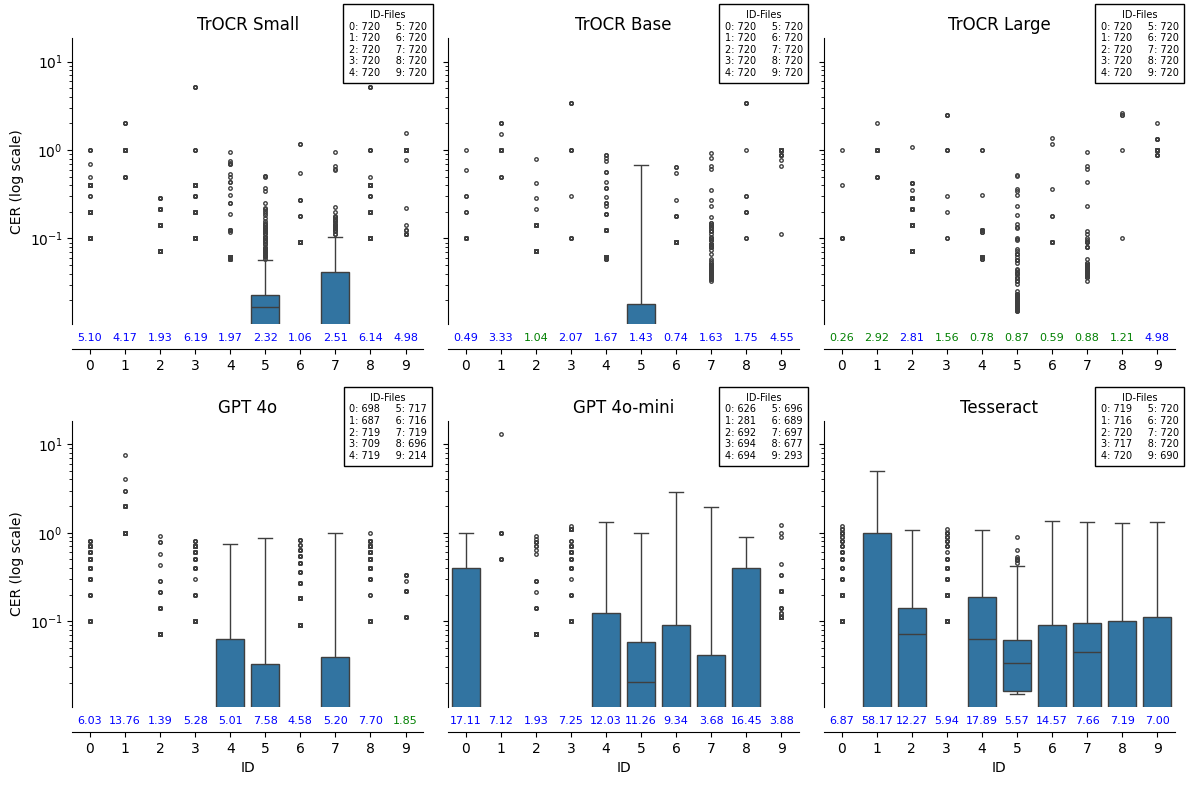

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

base_folders = {
    "/content/drive/MyDrive/TR OCR Small/metricas": "TrOCR Small",
    "/content/drive/MyDrive/TR OCR Base/metricas": "TrOCR Base",
    "/content/drive/MyDrive/TR OCR Large/metricas": "TrOCR Large",
    "/content/drive/MyDrive/GPT/metricas_gpt": "GPT 4o",
    "/content/drive/MyDrive/GPT/metricas_gpt_mini": "GPT 4o-mini",
    "/content/drive/MyDrive/Tesseract/metricas_pt": "Tesseract"
}

image_list_file = '/content/drive/MyDrive/dataset/test_files.txt'

with open(image_list_file, 'r') as f:
    folders_to_process = f.read().strip().split(',')
    folders_to_process = [folder.strip() for folder in folders_to_process]

possible_ids = list(range(10))
data = []
dfs = {}
id_counts = {}

for base_folder, method_name in base_folders.items():
    method_data = []
    id_counts[method_name] = {id_: 0 for id_ in possible_ids}

    for folder in folders_to_process:
        folder_path = os.path.join(base_folder, folder)
        if os.path.exists(folder_path):
            txt_files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
            if txt_files:
                file_path = os.path.join(folder_path, txt_files[0])
                values = {id_: None for id_ in possible_ids}
                with open(file_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 2:
                            id_value = int(parts[0])
                            value = float(parts[1])
                            values[id_value] = value

                for id_, value in values.items():
                    if value is not None and id_ <= 9:
                        id_counts[method_name][id_] += 1
                        method_data.append({"Method": method_name, "ID": id_, "CER": value})

    if method_data:
        dfs[method_name] = pd.DataFrame(method_data)

df = pd.concat(dfs.values(), ignore_index=True) if dfs else pd.DataFrame()
if not df.empty:
    means = df.groupby(['ID', 'Method'])['CER'].mean().unstack(fill_value=None)
    min_mean_method = means.idxmin(axis=1)

    def plot_boxplot_with_mean(data, **kwargs):
        ax = plt.gca()
        method_name = data["Method"].iloc[0]
        sns.boxplot(x="ID", y="CER", data=data, ax=ax, flierprops={'marker': '.', 'markersize': 5})

        means = data.groupby("ID")["CER"].mean()
        for id_, mean_value in means.items():
            mean_percentage = round(mean_value * 100, 2)
            color = 'green' if method_name == min_mean_method[id_] else 'blue'
            ax.text(id_, 0.007, f'{mean_percentage:.2f}',
                    horizontalalignment='center', color=color, fontsize=8, weight='normal')

        counts_list = [f"{id_}: {count}" for id_, count in id_counts[method_name].items()]
        mid = len(counts_list) // 2
        column1 = counts_list[:mid]
        column2 = counts_list[mid:]
        counts_text = "ID-Files\n" + "\n".join(f"{c1:<10} {c2}" for c1, c2 in zip(column1, column2))
        if len(column1) > len(column2):
            counts_text += f"\n{column1[-1]}"

        ax.text(0.90, 1.1, counts_text, transform=ax.transAxes, fontsize=7,
                verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='white', alpha=1))

        ax.set_yscale("log", nonpositive='clip')

        y_min, y_max = ax.get_ylim()
        space = (y_max - y_min) * 0.08
        ax.spines["bottom"].set_position(("outward", 18))
        ax.axhline(y_min - space, color="black", linewidth=1)

    g = sns.FacetGrid(df, col="Method", col_wrap=3, height=4, sharex=True, sharey=True)
    g.map_dataframe(plot_boxplot_with_mean)
    g.set_axis_labels("ID", "CER (log scale)")

    for ax, title in zip(g.axes.flat, base_folders.values()):
        ax.set_title(title)

    plt.show()


In [ ]:
output_path = "/content/drive/MyDrive/graph_metrics.pdf"
g.savefig(output_path, format="pdf", dpi=300, bbox_inches="tight")